# Proyecto de limpieza de datos
Autor: Iñaki Sebastián Orozco García    

Fecha: 24/11/2024

Para este proyecto usaré un dataset de BackBlaze una empresa de servidores que lleva años recabando la información S.M.A.R.T (Métricas estandarizadas de evaluación) de los discos duros de sus equipos con el atributo agregado Failure que indica si ese disco falló al día siguiente, este dataset es en el que he estado trabajando en mi proyecto de tesis para hacer predicciones de fallas con un árbol de decisión y una LSTM. 

Los 3 puntos en los que trabajaré en este proyecto giran en torno a un buen desempeño usando este set de datos en esos dos algoritmos (DT, LSTM) donde ya hay un trabajo previo en donde se buscó un set de datos que tuviera buen desempeño y se encontró que los mejores atributos son los presentes en varios documentos del estado del arte, son los siguientes:
[SMART Attribute list](https://en.wikipedia.org/wiki/Self-Monitoring,_Analysis_and_Reporting_Technology)
| ID # | Attribute Name                     | Column Index | Column Name                |
|------|------------------------------------|--------------|----------------------------|
| 1    | Raw Read Error Rate                | 11           | smart_1_normalized         |
| 3    | Spin Up Time                       | 13           | smart_3_normalized         |
| 5    | Reallocated Sectors Count          | 17           | smart_5_normalized         |
| 7    | Seek Error Rate                    | 21           | smart_7_normalized         |
| 9    | Power On Hours                     | 25           | smart_9_normalized         |
| 187  | Reported Uncorrectable Errors      | 187          | smart_187_normalized       |
| 189  | High Fly Writes                    | 191          | smart_189_normalized       |
| 194  | Temperature Celsius                | 195          | smart_194_normalized       |
| 195  | Hardware ECC Recovered             | 197          | smart_195_normalized       |
| 197  | Current Pending Sector Count       | 199          | smart_197_normalized       |
| 5    | Reallocated Sectors Count (raw value) | 18        | smart_5_raw                |
| 197  | Current Pending Sector Count (raw value) | 200    | smart_197_raw              |


In [74]:
S_O_T_A_features = [f"smart_{i}_normalized" for i in [1, 3, 5, 7, 9, 187, 189, 194, 195, 197]]
S_O_T_A_features += ["smart_5_raw", "smart_197_raw"]

- Imputación de datos faltantes             <- Elegida 
- Codificación de variables categóricas     <- Elegida
- Transformación de potencia
- Escalamiento                              <- Elegida
- Discretización

Esto es lo que se hará con las columnas del dataframe:

- date: Nada, nos sirve para la LSTM.
- serial_number: Variable categórica.
- model: Variable categórica, se va a dividir dos variables: Empresa y modelo.
- capacity_bytes: Variable categórica.
- failure: Nada.
---------
- datacenter: Eliminarla, no es reelevante para nosotros le sirve a la empresa que comparte el set de datos.
- cluster_id: Eliminarla, no es reelevante para nosotros le sirve a la empresa que comparte el set de datos.
- vault_id: Eliminarla, no es reelevante para nosotros le sirve a la empresa que comparte el set de datos.
- pod_id: Eliminarla, no es reelevante para nosotros le sirve a la empresa que comparte el set de datos.
- pod_slot_num: Eliminarla, no es reelevante para nosotros le sirve a la empresa que comparte el set de datos.
- is_legacy_format: Eliminarla, no es reelevante para nosotros le sirve a la empresa que comparte el set de datos.
--------

y también los smart que son de dos tipos:
- smart_normalized: si pertenece a los atributos, vamos a sustituir con media, moda o mediana dependiendo sea necesario
- smart_raw: si pertenece a los atributos, vamos a sustituir con media, moda o mediana dependiendo sea necesario

# Procesamiento inicial 

### Importar el set de datos en un dataframe de pandas

In [75]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import tree

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from feature_engine.imputation import RandomSampleImputer

Como nuestro dataset tiene muchos datos, definiré unas funciones para procesar los datos en chunks eliminando las columnas que no nos interesan sin cargarlas al df.

In [76]:
def delete_rows(df):
    df.head()
    columns_to_delete = ['datacenter', 'cluster_id', 'vault_id', 'pod_id', 'pod_slot_num', 'is_legacy_format']
    columns_to_delete += [col for col in df.columns if col.startswith('smart') and col not in S_O_T_A_features]
    df = df.drop(columns=columns_to_delete)

    failed_drives = df[df['failure'] == True]
    non_failed_drives = df[df['failure'] == False].sample(n=5*len(failed_drives), random_state=42)
    result_df = pd.concat([failed_drives, non_failed_drives])
    result_df = result_df.sample(frac=1, random_state=42)

    df = result_df
    return df

def process_chunks(file_path):
    chunksize = 10 ** 6
    dtype_dict = {'date': 'str', 'serial_number': 'str', 'model': 'str', 'capacity_bytes': 'object', 'failure': 'bool', 'datacenter': 'str', 'cluster_id': 'int8', 'vault_id': 'int16', 'pod_id': 'int16', 'pod_slot_num': 'float32', 'is_legacy_format': 'bool', 'smart_1_normalized': 'float64', 'smart_1_raw': 'float64', 'smart_2_normalized': 'float64', 'smart_2_raw': 'float64', 'smart_3_normalized': 'float64', 'smart_3_raw': 'float64', 'smart_4_normalized': 'float64', 'smart_4_raw': 'float64', 'smart_5_normalized': 'float64', 'smart_5_raw': 'float64', 'smart_7_normalized': 'float64', 'smart_7_raw': 'float64', 'smart_8_normalized': 'float64', 'smart_8_raw': 'float64', 'smart_9_normalized': 'float64', 'smart_9_raw': 'float64', 'smart_10_normalized': 'float64', 'smart_10_raw': 'float64', 'smart_11_normalized': 'float64', 'smart_11_raw': 'float64', 'smart_12_normalized': 'float64', 'smart_12_raw': 'float64', 'smart_13_normalized': 'float64', 'smart_13_raw': 'float64', 'smart_15_normalized': 'float64', 'smart_15_raw': 'float64', 'smart_16_normalized': 'float64', 'smart_16_raw': 'float64', 'smart_17_normalized': 'float64', 'smart_17_raw': 'float64', 'smart_18_normalized': 'float64', 'smart_18_raw': 'float64', 'smart_22_normalized': 'float64', 'smart_22_raw': 'float64', 'smart_23_normalized': 'float64', 'smart_23_raw': 'float64', 'smart_24_normalized': 'float64', 'smart_24_raw': 'float64', 'smart_27_normalized': 'float64', 'smart_27_raw': 'float64', 'smart_71_normalized': 'float64', 'smart_71_raw': 'float64', 'smart_82_normalized': 'float64', 'smart_82_raw': 'float64', 'smart_90_normalized': 'float64', 'smart_90_raw': 'float64', 'smart_160_normalized': 'float64', 'smart_160_raw': 'float64', 'smart_161_normalized': 'float64', 'smart_161_raw': 'float64', 'smart_163_normalized': 'float64', 'smart_163_raw': 'float64', 'smart_164_normalized': 'float64', 'smart_164_raw': 'float64', 'smart_165_normalized': 'float64', 'smart_165_raw': 'float64', 'smart_166_normalized': 'float64', 'smart_166_raw': 'float64', 'smart_167_normalized': 'float64', 'smart_167_raw': 'float64', 'smart_168_normalized': 'float64', 'smart_168_raw': 'float64', 'smart_169_normalized': 'float64', 'smart_169_raw': 'float64', 'smart_170_normalized': 'float64', 'smart_170_raw': 'float64', 'smart_171_normalized': 'float64', 'smart_171_raw': 'float64', 'smart_172_normalized': 'float64', 'smart_172_raw': 'float64', 'smart_173_normalized': 'float64', 'smart_173_raw': 'float64', 'smart_174_normalized': 'float64', 'smart_174_raw': 'float64', 'smart_175_normalized': 'float64', 'smart_175_raw': 'float64', 'smart_176_normalized': 'float64', 'smart_176_raw': 'float64', 'smart_177_normalized': 'float64', 'smart_177_raw': 'float64', 'smart_178_normalized': 'float64', 'smart_178_raw': 'float64', 'smart_179_normalized': 'float64', 'smart_179_raw': 'float64', 'smart_180_normalized': 'float64', 'smart_180_raw': 'float64', 'smart_181_normalized': 'float64', 'smart_181_raw': 'float64', 'smart_182_normalized': 'float64', 'smart_182_raw': 'float64', 'smart_183_normalized': 'float64', 'smart_183_raw': 'float64', 'smart_184_normalized': 'float64', 'smart_184_raw': 'float64', 'smart_187_normalized': 'float64', 'smart_187_raw': 'float64', 'smart_188_normalized': 'float64', 'smart_188_raw': 'float64', 'smart_189_normalized': 'float64', 'smart_189_raw': 'float64', 'smart_190_normalized': 'float64', 'smart_190_raw': 'float64', 'smart_191_normalized': 'float64', 'smart_191_raw': 'float64', 'smart_192_normalized': 'float64', 'smart_192_raw': 'float64', 'smart_193_normalized': 'float64', 'smart_193_raw': 'float64', 'smart_194_normalized': 'float64', 'smart_194_raw': 'float64', 'smart_195_normalized': 'float64', 'smart_195_raw': 'float64', 'smart_196_normalized': 'float64', 'smart_196_raw': 'float64', 'smart_197_normalized': 'float64', 'smart_197_raw': 'float64', 'smart_198_normalized': 'float64', 'smart_198_raw': 'float64', 'smart_199_normalized': 'float64', 'smart_199_raw': 'float64', 'smart_200_normalized': 'float64', 'smart_200_raw': 'float64', 'smart_201_normalized': 'float64', 'smart_201_raw': 'float64', 'smart_202_normalized': 'float64', 'smart_202_raw': 'float64', 'smart_206_normalized': 'float64', 'smart_206_raw': 'float64', 'smart_210_normalized': 'float64', 'smart_210_raw': 'float64', 'smart_218_normalized': 'float64', 'smart_218_raw': 'float64', 'smart_220_normalized': 'float64', 'smart_220_raw': 'float64', 'smart_222_normalized': 'float64', 'smart_222_raw': 'float64', 'smart_223_normalized': 'float64', 'smart_223_raw': 'float64', 'smart_224_normalized': 'float64', 'smart_224_raw': 'float64', 'smart_225_normalized': 'float64', 'smart_225_raw': 'float64', 'smart_226_normalized': 'float64', 'smart_226_raw': 'float64', 'smart_230_normalized': 'float64', 'smart_230_raw': 'float64', 'smart_231_normalized': 'float64', 'smart_231_raw': 'float64', 'smart_232_normalized': 'float64', 'smart_232_raw': 'float64', 'smart_233_normalized': 'float64', 'smart_233_raw': 'float64', 'smart_234_normalized': 'float64', 'smart_234_raw': 'float64', 'smart_235_normalized': 'float64', 'smart_235_raw': 'float64', 'smart_240_normalized': 'float64', 'smart_240_raw': 'float64', 'smart_241_normalized': 'float64', 'smart_241_raw': 'float64', 'smart_242_normalized': 'float64', 'smart_242_raw': 'float64', 'smart_244_normalized': 'float64', 'smart_244_raw': 'float64', 'smart_245_normalized': 'float64', 'smart_245_raw': 'float64', 'smart_246_normalized': 'float64', 'smart_246_raw': 'float64', 'smart_247_normalized': 'float64', 'smart_247_raw': 'float64', 'smart_248_normalized': 'float64', 'smart_248_raw': 'float64', 'smart_250_normalized': 'float64', 'smart_250_raw': 'float64', 'smart_251_normalized': 'float64', 'smart_251_raw': 'float64', 'smart_252_normalized': 'float64', 'smart_252_raw': 'float64', 'smart_254_normalized': 'float64', 'smart_254_raw': 'float64', 'smart_255_normalized': 'float64', 'smart_255_raw': 'float64', 'capacity_gb': 'float64'}
    aggregated_result = pd.DataFrame() 

    for chunk in pd.read_csv(file_path, chunksize=chunksize, dtype=dtype_dict):
        chunk = delete_rows(chunk)
        aggregated_result = pd.concat([aggregated_result, chunk])

    return aggregated_result

def delete_rows(df):
    df.head()
    columns_to_delete = ['datacenter', 'cluster_id', 'vault_id', 'pod_id', 'pod_slot_num', 'is_legacy_format']
    columns_to_delete += [col for col in df.columns if col.startswith('smart') and col not in S_O_T_A_features]
    df = df.drop(columns=columns_to_delete)
    
    return df


def getdata(folder_path, num_files=-1):
    df = pd.DataFrame()
    for idx, file_name in enumerate(os.listdir(folder_path)):
        if num_files == -1:
            if file_name.endswith(".csv"):
                file_path = os.path.join(folder_path, file_name)
                temp_df = process_chunks(file_path)
                df = pd.concat([df, temp_df])
                print(file_path, ' done')
        elif num_files > 0:
            if num_files == idx-1:
                return df
            if file_name.endswith(".csv"):
                file_path = os.path.join(folder_path, file_name)
                temp_df = process_chunks(file_path)
                df = pd.concat([df, temp_df])
                print(file_path, ' done')
    print(df.columns)
    return df

Cargamos los datos en el df sin las columnas innecesarias

In [77]:
folder_path = '../data/external/data_Q3_2024/data_Q3_2024'

In [78]:
df = getdata(folder_path, 20)

../data/external/data_Q3_2024/data_Q3_2024\2024-07-01.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-02.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-03.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-04.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-05.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-06.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-07.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-08.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-09.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-10.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-11.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-12.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-13.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-14.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-15.csv  done
../data/external/data_Q3_2024/data_Q3_20

### Analizamos el dataframe 

Generamos un varias gráficas de mapas de calor para visualizar el df y los atributos nulos que tiene.

In [79]:
sns.heatmap(df.isnull(), cbar=False)
plt.tight_layout()  # Adjust the layout to ensure nothing is cut off
plt.show()
plt.savefig(f'../reports/figures/heat_maps/heat_map_.png')
plt.close()

MemoryError: Unable to allocate 2.93 GiB for an array with shape (5793021, 17, 4) and data type float64

<Figure size 640x480 with 1 Axes>

Podemos ver esas 3 variables que tienen muchos datos nulos, pero como ya vimos que nuestro modelo del arbol de decisión tiene buen desempeño incluso con tantos datos faltantes intentaremos trabajar con ellas

Ahora eliminaremos las columnas que solo tienen datos faltantes.

In [80]:
nan_columns = df.columns[df.isna().all()].tolist()
print(f"Columns with only NaN values: {nan_columns}")

df = df.drop(columns=nan_columns)

Columns with only NaN values: []


Imprimimos las columnas y los elementos que más aparecen para hacernos una idea de que que haremos con los distintos datos.

In [81]:
for column in df.columns:
    print(f"Column: {column}")
    print(f"Top 3 most occurring elements: {df[column].value_counts().head(3).to_dict().keys()}")
    print(f"Number of NaN values: {df[column].isna().sum()}")
    print("\n")

Column: date
Top 3 most occurring elements: dict_keys(['2024-07-20', '2024-07-19', '2024-07-18'])
Number of NaN values: 0


Column: serial_number
Top 3 most occurring elements: dict_keys(['PL1331LAGXN3AH', '8160A0F2FVKG', '8160A0HVFVKG'])
Number of NaN values: 0


Column: model
Top 3 most occurring elements: dict_keys(['TOSHIBA MG08ACA16TA', 'TOSHIBA MG07ACA14TA', 'ST16000NM001G'])
Number of NaN values: 0


Column: capacity_bytes
Top 3 most occurring elements: dict_keys(['16000900661248', '12000138625024', '14000519643136'])
Number of NaN values: 0


Column: failure
Top 3 most occurring elements: dict_keys([False, True])
Number of NaN values: 0


Column: smart_1_normalized
Top 3 most occurring elements: dict_keys([100.0, 83.0, 82.0])
Number of NaN values: 16436


Column: smart_3_normalized
Top 3 most occurring elements: dict_keys([100.0, 84.0, 90.0])
Number of NaN values: 69293


Column: smart_5_normalized
Top 3 most occurring elements: dict_keys([100.0, 99.0, 252.0])
Number of NaN val

Podemos ver que las columnas con variables categóricas no tienen variables faltantes, vamos a trabajar solo reemplazando datos faltantes con las variables numéricas que pertenecen a los atributos S.M.A.R.T, hay normalizadas y crudas.

In [82]:
for column in df.columns:
    nan_count = df[column].isna().sum()
    if nan_count > 0:
        print(f"Column: {column}, NaN values: {nan_count}")

Column: smart_1_normalized, NaN values: 16436
Column: smart_3_normalized, NaN values: 69293
Column: smart_5_normalized, NaN values: 48072
Column: smart_5_raw, NaN values: 48072
Column: smart_7_normalized, NaN values: 69293
Column: smart_9_normalized, NaN values: 10746
Column: smart_187_normalized, NaN values: 3626688
Column: smart_189_normalized, NaN values: 5257635
Column: smart_194_normalized, NaN values: 10746
Column: smart_195_normalized, NaN values: 4867111
Column: smart_197_normalized, NaN values: 173789
Column: smart_197_raw, NaN values: 173789


# Imputación de datos faltantes
----------
[Tratamiento de datos faltantes](../references/Tratamiento_de_datos_faltantes_PDF.pdf)

La moda se usa para imputar predictores cualitativos (Variables categóricas) y el promedio o la mediana se usa para imputar predictores
cuantitativos (Variables numéricas).

### Variables categóricas

Variables categóricas con elementos NaN del dataset: ninguna

In [83]:
nan_counts = df.iloc[:, :5].isna().sum()
print(nan_counts)

date              0
serial_number     0
model             0
capacity_bytes    0
failure           0
dtype: int64


### Variables numéricas
Evaluamos la distribución:

En una distribución uniforme, el método a emplear debe ser la sustitución aleatoria; en cambio, si la distribución es semejante a la normal, es decir, simétrica y curtósis mayor a -1.0, si la variable muestra datos atípicos, se
aplica la sustitución por mediana, ya que esta medida de tendencia central no varía en la presencia de tales valores;
de lo contrario, se usa la sustitución por media aritmética

In [84]:
output_dir = '../reports/figures/histogramas/'
os.makedirs(output_dir, exist_ok=True)

# Crear histogramas para las columnas 6 en adelante
for column in df.columns[5:]:
    plt.figure(figsize=(10, 6))
    df[column].dropna().hist(bins=50)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.savefig(f'{output_dir}{column}_histograma.png')
    plt.close()

Sustitución aleatoria (Kurtosis menor a -1.0 y distribución uniforme)

Columnas con kurtosis menor a -1.0: ['smart_195_normalized']


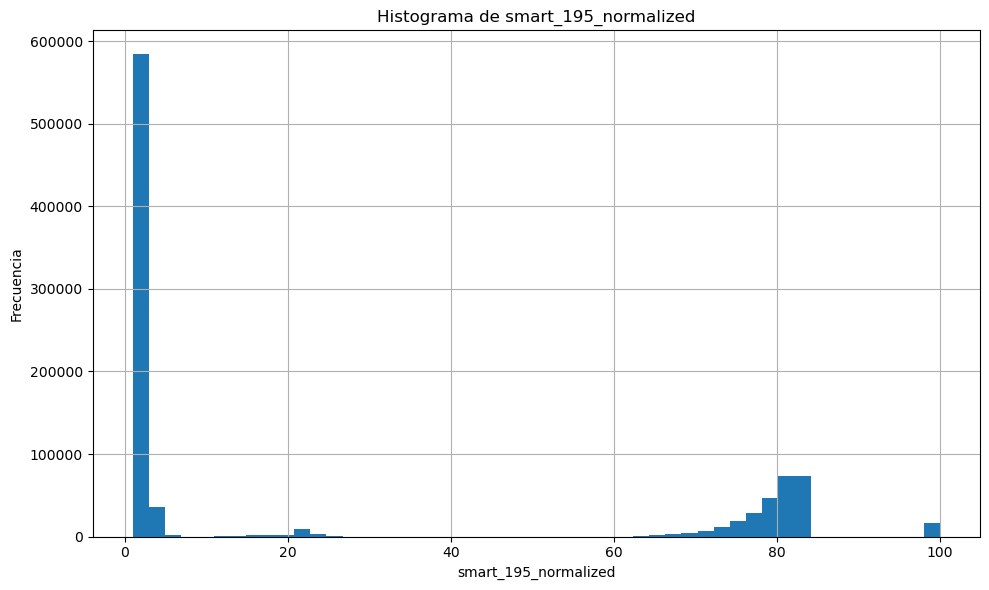

In [85]:
df_smart = df.iloc[:, 5:]
kurtosis_columns = [col for col in df_smart.columns if df_smart[col].kurtosis() < -1.0]
print(f"Columnas con kurtosis menor a -1.0: {kurtosis_columns}")
# Plot the column with kurtosis less than -1.0
for col in kurtosis_columns:
    plt.figure(figsize=(10, 6))
    df[col].dropna().hist(bins=50)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.savefig(f'../reports/figures/histogramas/{col}_histograma.png')
    plt.tight_layout()
    plt.show()
    plt.close()


#### Analizamos en búsqueda de datos atípicos:

Con el IQR vemos que columnas tienen anomalías y las guardamos en un diccionario

In [86]:
# Calcular el rango intercuartílico (IQR) para las columnas 6 en adelante
iqr_values = {}
outliers_dict = {}
no_kurtosis_df = df.drop(columns=kurtosis_columns)
for column in no_kurtosis_df.columns[5:]:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    iqr_values[column] = IQR
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    print(f"Outliers in column {column}: {outliers.shape[0]}")
    if not outliers.empty:
        outliers_dict[column] = outliers

Outliers in column smart_1_normalized: 2708
Outliers in column smart_3_normalized: 373933
Outliers in column smart_5_normalized: 20650
Outliers in column smart_5_raw: 220233
Outliers in column smart_7_normalized: 36481
Outliers in column smart_9_normalized: 0
Outliers in column smart_187_normalized: 81495
Outliers in column smart_189_normalized: 21570
Outliers in column smart_194_normalized: 193395
Outliers in column smart_197_normalized: 7171
Outliers in column smart_197_raw: 76560


Creamos el diccionario para sustituir los valores nulos

In [87]:
valores = {}
for column in df.columns[5:]:
    if column not in kurtosis_columns:
        if column in outliers:
            valores[column] = df[column].median()
        else:
            valores[column] = df[column].mean()

print(valores)

{'smart_1_normalized': 100.0, 'smart_3_normalized': 97.0, 'smart_5_normalized': 100.0, 'smart_5_raw': 0.0, 'smart_7_normalized': 100.0, 'smart_9_normalized': 74.0, 'smart_187_normalized': 100.0, 'smart_189_normalized': 100.0, 'smart_194_normalized': 62.0, 'smart_197_normalized': 100.0, 'smart_197_raw': 0.0}


In [88]:
df=df.fillna(valores)
num_columns_with_nan = df.isna().any().sum()
print(f"Number of columns with NaN values: {num_columns_with_nan}")

Number of columns with NaN values: 1


In [89]:

aleatorio=RandomSampleImputer()
for column in kurtosis_columns:
    df[column]=aleatorio.fit_transform(df[[column]])
num_columns_with_nan = df.isna().any().sum()
print(f"Number of columns with NaN values: {num_columns_with_nan}")

Number of columns with NaN values: 0


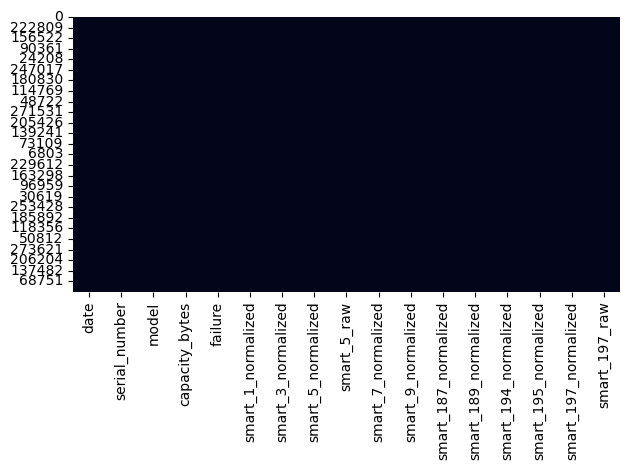

In [90]:
sns.heatmap(df.isnull(), cbar=False)
plt.tight_layout()  # Adjust the layout to ensure nothing is cut off
plt.show()
plt.close()

# Codificación de variables categóricas
-------------
[Codificación de variables categóricas](../references/codificacion_var_categoricas.pdf)

Variables que convertiremos a una variable categórica:
- model: Se va a dividir dos variables: Empresa y modelo.
- capacity_bytes: los separaremos en distintas categorías dependiendo de la cantidad de almacenamiento


In [91]:
# Calcular la frecuencia de cada modelo
model_freq = df['model'].value_counts()

# Crear un diccionario para mapear cada modelo a su frecuencia
model_freq_dict = model_freq.to_dict()

# Crear una nueva columna categórica basada en la frecuencia de uso
df['model_freq'] = df['model'].map(model_freq_dict)

# Convertir la nueva columna a tipo categórico
df['model_freq'] = pd.cut(df['model_freq'], bins=[0, 10, 100, 1000, 10000, float('inf')],
                          labels=['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto'])

print(df[['model', 'model_freq']].head())

                  model model_freq
0  HGST HDS5C4040ALE630       Bajo
1  HGST HMS5C4040ALE640   Muy Alto
2         ST500LM012 HN       Alto
3           ST4000DM000   Muy Alto
4           ST4000DM000   Muy Alto


Se dividen en marca y modelo

In [92]:
import re

def extract_brand(model):
    match = re.match(r'^[A-Za-z]+', model)
    return match.group(0) if match else None

df['brand'] = df['model'].apply(extract_brand)
print(df['brand'].drop_duplicates())

0             HGST
2               ST
46         TOSHIBA
459        Seagate
509            WDC
873            WUH
980             WD
1102            CT
1468        Micron
2368       Hitachi
41825     DELLBOSS
150912     MTFDDAV
151848    SSDSCKKB
Name: brand, dtype: object


In [93]:
print(df.head())

         date   serial_number                 model capacity_bytes  failure  \
0  2024-07-01  PL1331LAGXN3AH  HGST HDS5C4040ALE630  4000787030016    False   
1  2024-07-01  PL2331LAGSTSYJ  HGST HMS5C4040ALE640  4000787030016    False   
2  2024-07-01  S2ZYJ9FG405079         ST500LM012 HN   500107862016    False   
3  2024-07-01        Z3056CGY           ST4000DM000  4000787030016    False   
4  2024-07-01        Z305FT10           ST4000DM000  4000787030016    False   

   smart_1_normalized  smart_3_normalized  smart_5_normalized  smart_5_raw  \
0               100.0               130.0               100.0          0.0   
1               100.0               128.0               100.0          0.0   
2               100.0                94.0               252.0          0.0   
3               120.0                92.0               100.0          0.0   
4               114.0                91.0               100.0          0.0   

   smart_7_normalized  smart_9_normalized  smart_187_nor

Ahora se aplica OH a la marca y la frecuencia del modelo

In [94]:
df = pd.get_dummies(df, columns=['brand', 'model_freq'])
print(df.head())

         date   serial_number                 model capacity_bytes  failure  \
0  2024-07-01  PL1331LAGXN3AH  HGST HDS5C4040ALE630  4000787030016    False   
1  2024-07-01  PL2331LAGSTSYJ  HGST HMS5C4040ALE640  4000787030016    False   
2  2024-07-01  S2ZYJ9FG405079         ST500LM012 HN   500107862016    False   
3  2024-07-01        Z3056CGY           ST4000DM000  4000787030016    False   
4  2024-07-01        Z305FT10           ST4000DM000  4000787030016    False   

   smart_1_normalized  smart_3_normalized  smart_5_normalized  smart_5_raw  \
0               100.0               130.0               100.0          0.0   
1               100.0               128.0               100.0          0.0   
2               100.0                94.0               252.0          0.0   
3               120.0                92.0               100.0          0.0   
4               114.0                91.0               100.0          0.0   

   smart_7_normalized  ...  brand_Seagate  brand_TOSHIBA

### Convirtiendo a categórica ordinal capacity_bytes:

Aquí hay un problema grave y es que el df empieza a eliminar datos de la columna capacity_bytes y los reemplaza por un -1 a su antojo, he estado 4 horas intentando solucionarlo y no he podido, al parecer al cargar el segundo archivo csv, muchos datos del 1 se reemplazan por -1 en vez de por su dato normal, si solo cargo 1 csv esto no se observa. Este problema está explorado en el archivo 

[data_corruption_test](data_corruption_test.py)

In [95]:
print(df['capacity_bytes'].unique())

['4000787030016' '500107862016' '16000900661248' '250059350016'
 '8001563222016' '480103981056' '2000398934016' '12000138625024'
 '10000831348736' '14000519643136' '480036847616' '1000204886016'
 '18000207937536' '240057409536' '22000969973760' '20000588955648' '-1'
 '137438952960']


Aunque tenemos este error vamos a manejar los datos como si la información no se corrompiera, seguiré explorando la manera de cargar correctamente la información de esa columna

In [96]:
Var=df['capacity_bytes']                      # Variable categórica ordinal
n=Var.nunique()                     # Cardinalidad
lim_inf=(n-1)//2 if n%2!=0 else n-1 # Abs del límite inferior
step=1 if n%2!=0 else 2             # Intervalo
X=range(-lim_inf,lim_inf+1,step)
list(X)

[-17, -15, -13, -11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11, 13, 15, 17]

In [97]:
#Var = Var.astype(np.int64)
print(Var.unique())

['4000787030016' '500107862016' '16000900661248' '250059350016'
 '8001563222016' '480103981056' '2000398934016' '12000138625024'
 '10000831348736' '14000519643136' '480036847616' '1000204886016'
 '18000207937536' '240057409536' '22000969973760' '20000588955648' '-1'
 '137438952960']


In [98]:
beta0=0
beta1=1 # beta1>0  ->  codificación creciente. beta1<0  ->  codificación decreciente
y=[beta0+beta1*x for x in X]
y

[-17, -15, -13, -11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11, 13, 15, 17]

In [99]:
# Asociamos estos valores a las categorías ordenadas de 'Var'
# Var.unique()
Var_ord = np.sort(Var.unique())
Var_ord

array(['-1', '10000831348736', '1000204886016', '12000138625024',
       '137438952960', '14000519643136', '16000900661248',
       '18000207937536', '20000588955648', '2000398934016',
       '22000969973760', '240057409536', '250059350016', '4000787030016',
       '480036847616', '480103981056', '500107862016', '8001563222016'],
      dtype=object)

In [100]:
map_lin_CB={categoria:codificacion for categoria,codificacion in zip(Var_ord,y)}
map_lin_CB

{'-1': -17,
 '10000831348736': -15,
 '1000204886016': -13,
 '12000138625024': -11,
 '137438952960': -9,
 '14000519643136': -7,
 '16000900661248': -5,
 '18000207937536': -3,
 '20000588955648': -1,
 '2000398934016': 1,
 '22000969973760': 3,
 '240057409536': 5,
 '250059350016': 7,
 '4000787030016': 9,
 '480036847616': 11,
 '480103981056': 13,
 '500107862016': 15,
 '8001563222016': 17}

In [101]:
df['Lin_capacity_bytes']=df['capacity_bytes'].map(map_lin_CB)

df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_3_normalized,smart_5_normalized,smart_5_raw,smart_7_normalized,...,brand_TOSHIBA,brand_WD,brand_WDC,brand_WUH,model_freq_Muy Bajo,model_freq_Bajo,model_freq_Medio,model_freq_Alto,model_freq_Muy Alto,Lin_capacity_bytes
0,2024-07-01,PL1331LAGXN3AH,HGST HDS5C4040ALE630,4000787030016,False,100.0,130.0,100.0,0.0,100.0,...,False,False,False,False,False,True,False,False,False,9
1,2024-07-01,PL2331LAGSTSYJ,HGST HMS5C4040ALE640,4000787030016,False,100.0,128.0,100.0,0.0,100.0,...,False,False,False,False,False,False,False,False,True,9
2,2024-07-01,S2ZYJ9FG405079,ST500LM012 HN,500107862016,False,100.0,94.0,252.0,0.0,252.0,...,False,False,False,False,False,False,False,True,False,15
3,2024-07-01,Z3056CGY,ST4000DM000,4000787030016,False,120.0,92.0,100.0,0.0,81.0,...,False,False,False,False,False,False,False,False,True,9
4,2024-07-01,Z305FT10,ST4000DM000,4000787030016,False,114.0,91.0,100.0,0.0,83.0,...,False,False,False,False,False,False,False,False,True,9


### Probar con el árbol de decisión:

In [102]:
def div_test_train(df):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    X_train = train_df.drop(columns=['failure'])
    y_train = train_df['failure']
    X_test = test_df.drop(columns=['failure'])
    y_test = test_df['failure']

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f'before SMOTE: {y_train.value_counts()}, after SMOTE: {y_train_resampled.value_counts()}')
    return X_train_resampled, y_train_resampled, X_test, y_test

def DT(X_train_resampled, y_train_resampled, X_test, y_test):
    clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, random_state=42)

    clf.fit(X_train_resampled, y_train_resampled)

    y_pred = clf.predict(X_test)

    # Evaluate the model
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    return clf

In [103]:
df.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_3_normalized', 'smart_5_normalized',
       'smart_5_raw', 'smart_7_normalized', 'smart_9_normalized',
       'smart_187_normalized', 'smart_189_normalized', 'smart_194_normalized',
       'smart_195_normalized', 'smart_197_normalized', 'smart_197_raw',
       'brand_CT', 'brand_DELLBOSS', 'brand_HGST', 'brand_Hitachi',
       'brand_MTFDDAV', 'brand_Micron', 'brand_SSDSCKKB', 'brand_ST',
       'brand_Seagate', 'brand_TOSHIBA', 'brand_WD', 'brand_WDC', 'brand_WUH',
       'model_freq_Muy Bajo', 'model_freq_Bajo', 'model_freq_Medio',
       'model_freq_Alto', 'model_freq_Muy Alto', 'Lin_capacity_bytes'],
      dtype='object')

In [104]:
df = df.drop(columns=['date', 'serial_number', 'model', 'capacity_bytes'])

In [105]:
df.columns

Index(['failure', 'smart_1_normalized', 'smart_3_normalized',
       'smart_5_normalized', 'smart_5_raw', 'smart_7_normalized',
       'smart_9_normalized', 'smart_187_normalized', 'smart_189_normalized',
       'smart_194_normalized', 'smart_195_normalized', 'smart_197_normalized',
       'smart_197_raw', 'brand_CT', 'brand_DELLBOSS', 'brand_HGST',
       'brand_Hitachi', 'brand_MTFDDAV', 'brand_Micron', 'brand_SSDSCKKB',
       'brand_ST', 'brand_Seagate', 'brand_TOSHIBA', 'brand_WD', 'brand_WDC',
       'brand_WUH', 'model_freq_Muy Bajo', 'model_freq_Bajo',
       'model_freq_Medio', 'model_freq_Alto', 'model_freq_Muy Alto',
       'Lin_capacity_bytes'],
      dtype='object')

In [106]:
X_train_resampled, y_train_resampled, X_test, y_test = div_test_train(df)

before SMOTE: failure
False    4634189
True         227
Name: count, dtype: int64, after SMOTE: failure
False    4634189
True     4634189
Name: count, dtype: int64


In [107]:
clf = DT(X_train_resampled, y_train_resampled, X_test, y_test)

Confusion Matrix:
[[1121590   36949]
 [     27      39]]

Accuracy Score: 0.9680857583041675

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.97      0.98   1158539
        True       0.00      0.59      0.00        66

    accuracy                           0.97   1158605
   macro avg       0.50      0.78      0.49   1158605
weighted avg       1.00      0.97      0.98   1158605



Podemos ver que procesando los datos nuestro DT tiene muy buen score de acuraccy 

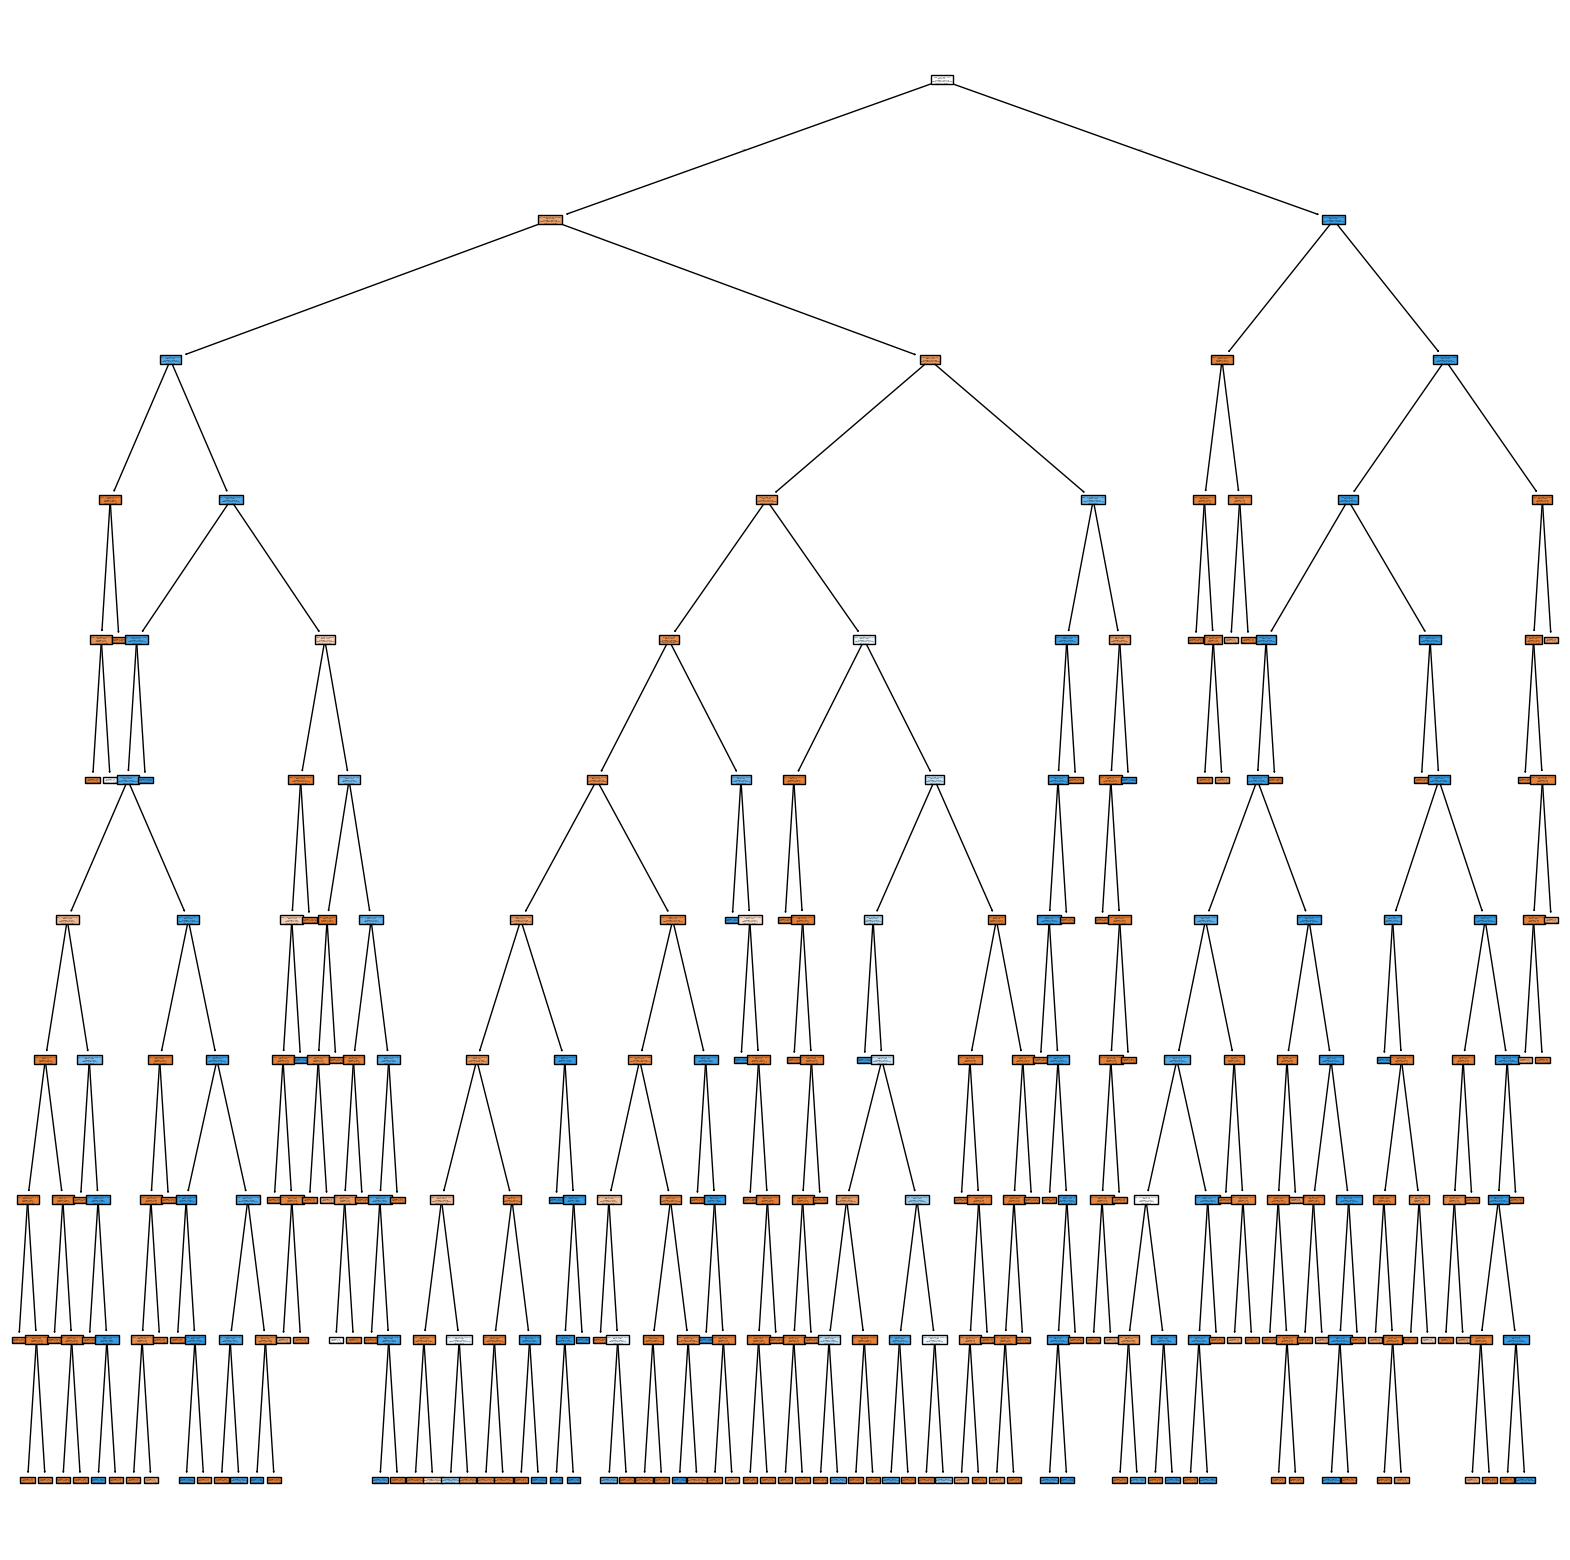

In [108]:
plt.figure(figsize=(20, 20))
tree.plot_tree(clf, filled=True, feature_names=X_train_resampled.columns, class_names=['non-failure', 'failure'])
plt.savefig('../reports/figures/decision_tree.png')

# Escalamiento
Las LSTM son sensibles al escalamiento, vamos a estandarizar los atributos S.M.A.R.T raw (por que los normalizados ya tienen escalamiento) de nuestro dataset para que tenga un mejor resultado en la LSTM


[Escalamiento de variables](../references/Escalamiento_de_variables_PDF.pdf)


In [114]:
print(df.columns)

Index(['failure', 'smart_1_normalized', 'smart_3_normalized',
       'smart_5_normalized', 'smart_5_raw', 'smart_7_normalized',
       'smart_9_normalized', 'smart_187_normalized', 'smart_189_normalized',
       'smart_194_normalized', 'smart_195_normalized', 'smart_197_normalized',
       'smart_197_raw', 'brand_CT', 'brand_DELLBOSS', 'brand_HGST',
       'brand_Hitachi', 'brand_MTFDDAV', 'brand_Micron', 'brand_SSDSCKKB',
       'brand_ST', 'brand_Seagate', 'brand_TOSHIBA', 'brand_WD', 'brand_WDC',
       'brand_WUH', 'model_freq_Muy Bajo', 'model_freq_Bajo',
       'model_freq_Medio', 'model_freq_Alto', 'model_freq_Muy Alto',
       'Lin_capacity_bytes'],
      dtype='object')


In [115]:
df_selected = df.iloc[:, [4, 12]]
print(df_selected.head())

   smart_5_raw  smart_197_raw
0          0.0            0.0
1          0.0            0.0
2          0.0            0.0
3          0.0            0.0
4          0.0            0.0


Lamentablemente en realidad estas dos variables no parecen ser muy útiles ya que tienen muy pocos datos y lo mejor sería eliminarla, pero para este proyecto vamos a estandarizarlas

In [117]:
for column in df.columns:
    zero_count = (df[column] == 0.0).sum()
    total_count = df[column].count()
    print(f"Column: {column}, 0.0 values: {zero_count}, Total values: {total_count}, Percentage: {zero_count / total_count * 100:.2f}%")

Column: failure, 0.0 values: 5792728, Total values: 5793021, Percentage: 99.99%
Column: smart_1_normalized, 0.0 values: 0, Total values: 5793021, Percentage: 0.00%
Column: smart_3_normalized, 0.0 values: 0, Total values: 5793021, Percentage: 0.00%
Column: smart_5_normalized, 0.0 values: 0, Total values: 5793021, Percentage: 0.00%
Column: smart_5_raw, 0.0 values: 5572788, Total values: 5793021, Percentage: 96.20%
Column: smart_7_normalized, 0.0 values: 0, Total values: 5793021, Percentage: 0.00%
Column: smart_9_normalized, 0.0 values: 0, Total values: 5793021, Percentage: 0.00%
Column: smart_187_normalized, 0.0 values: 0, Total values: 5793021, Percentage: 0.00%
Column: smart_189_normalized, 0.0 values: 0, Total values: 5793021, Percentage: 0.00%
Column: smart_194_normalized, 0.0 values: 0, Total values: 5793021, Percentage: 0.00%
Column: smart_195_normalized, 0.0 values: 0, Total values: 5793021, Percentage: 0.00%
Column: smart_197_normalized, 0.0 values: 0, Total values: 5793021, Perc

In [126]:
median_smart_5_raw = df_selected['smart_5_raw'].median()
median_smart_197_raw = df_selected['smart_197_raw'].median()

print(f"Median of smart_5_raw: {median_smart_5_raw}")
print(f"Median of smart_197_raw: {median_smart_197_raw}")

KeyError: 'smart_5_raw'

en este caso como nuestra media es 0 y la desviacion estandar es 1 los valores debajo de la media son negativos

In [122]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_selected = scaler.fit_transform(df_selected)

df_selected = pd.DataFrame(df_selected, columns=['smart_5_scaled', 'smart_197_scaled'])   

df_selected

,smart_5_scaled,smart_197_scaled
0,-0.035914,-0.006234
1,-0.035914,-0.006234
2,-0.035914,-0.006234
3,-0.035914,-0.006234
4,-0.035914,-0.006234
...,...,...
5793016,-0.035914,-0.006234
5793017,-0.035914,-0.006234
5793018,-0.031640,-0.006234
5793019,-0.035914,-0.006234


In [124]:

# Verificar si hay índices duplicados
print("Índices duplicados:")
print(df.index.duplicated())

df = df[~df.index.duplicated(keep='first')]

# Mostrar el DataFrame resultante
print("\nDataFrame sin índices duplicados:")
print(df)

Índices duplicados:
[False False False ... False False False]

DataFrame sin índices duplicados:
        failure  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
0         False               100.0               130.0               100.0   
1         False               100.0               128.0               100.0   
2         False               100.0                94.0               252.0   
3         False               120.0                92.0               100.0   
4         False               114.0                91.0               100.0   
...         ...                 ...                 ...                 ...   
291542    False               100.0               100.0               100.0   
291543    False               100.0               100.0               100.0   
291544    False               100.0               100.0               100.0   
291545    False               100.0               100.0               100.0   
291546    False               100.

Si no tuvieramos los problemas con tantos valores nulos al escalar tendríamos datos estandarizados para alimentar al modelo, agregaré las dos columnas y con eso podríamos entrenar a la LSTM

In [125]:
df = pd.concat([df, df_selected], axis=1)
print(df.head())

  failure  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
0   False               100.0               130.0               100.0   
1   False               100.0               128.0               100.0   
2   False               100.0                94.0               252.0   
3   False               120.0                92.0               100.0   
4   False               114.0                91.0               100.0   

   smart_5_raw  smart_7_normalized  smart_9_normalized  smart_187_normalized  \
0          0.0               100.0                91.0                 100.0   
1          0.0               100.0                89.0                 100.0   
2          0.0               252.0               100.0                 100.0   
3          0.0                81.0                17.0                 100.0   
4          0.0                83.0                17.0                 100.0   

   smart_189_normalized  smart_194_normalized  ...  brand_WDC  brand_WUH  \
0   

In [127]:
df.columns

Index(['failure', 'smart_1_normalized', 'smart_3_normalized',
       'smart_5_normalized', 'smart_5_raw', 'smart_7_normalized',
       'smart_9_normalized', 'smart_187_normalized', 'smart_189_normalized',
       'smart_194_normalized', 'smart_195_normalized', 'smart_197_normalized',
       'smart_197_raw', 'brand_CT', 'brand_DELLBOSS', 'brand_HGST',
       'brand_Hitachi', 'brand_MTFDDAV', 'brand_Micron', 'brand_SSDSCKKB',
       'brand_ST', 'brand_Seagate', 'brand_TOSHIBA', 'brand_WD', 'brand_WDC',
       'brand_WUH', 'model_freq_Muy Bajo', 'model_freq_Bajo',
       'model_freq_Medio', 'model_freq_Alto', 'model_freq_Muy Alto',
       'Lin_capacity_bytes', 'smart_5_scaled', 'smart_197_scaled'],
      dtype='object')

Ya tenemos las columnas en el df con todos los datos que manipulamos.

In [128]:
df.head()

,failure,smart_1_normalized,smart_3_normalized,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_9_normalized,smart_187_normalized,smart_189_normalized,smart_194_normalized,...,brand_WDC,brand_WUH,model_freq_Muy Bajo,model_freq_Bajo,model_freq_Medio,model_freq_Alto,model_freq_Muy Alto,Lin_capacity_bytes,smart_5_scaled,smart_197_scaled
0,False,100.0,130.0,100.0,0.0,100.0,91.0,100.0,100.0,230.0,...,False,False,False,True,False,False,False,9.0,-0.035914,-0.006234
1,False,100.0,128.0,100.0,0.0,100.0,89.0,100.0,100.0,253.0,...,False,False,False,False,False,False,True,9.0,-0.035914,-0.006234
2,False,100.0,94.0,252.0,0.0,252.0,100.0,100.0,100.0,64.0,...,False,False,False,False,False,True,False,15.0,-0.035914,-0.006234
3,False,120.0,92.0,100.0,0.0,81.0,17.0,100.0,100.0,22.0,...,False,False,False,False,False,False,True,9.0,-0.035914,-0.006234
4,False,114.0,91.0,100.0,0.0,83.0,17.0,100.0,100.0,24.0,...,False,False,False,False,False,False,True,9.0,-0.035914,-0.006234
